In [51]:
import pandas as pd
import numpy as np
from datetime import datetime
import os
import math

import yfinance as yf

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error

import pickle

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# import Infosys data
infy_data = yf.Ticker("INFY")
infy_df = infy_data.history(period="max")

In [3]:
infy_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1999-03-11 00:00:00-05:00,0.385778,0.516091,0.385778,0.483835,172512000,0.0,0.0
1999-03-12 00:00:00-05:00,0.485126,0.503189,0.443838,0.481255,39897600,0.0,0.0
1999-03-15 00:00:00-05:00,0.482545,0.482545,0.434806,0.437387,12672000,0.0,0.0
1999-03-16 00:00:00-05:00,0.441258,0.456740,0.433516,0.433516,9984000,0.0,0.0
1999-03-17 00:00:00-05:00,0.433517,0.461902,0.430936,0.436097,15449600,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-28 00:00:00-04:00,17.790001,17.990000,17.790001,17.930000,7019600,0.0,0.0
2024-04-01 00:00:00-04:00,17.889999,17.920000,17.500000,17.580000,14601600,0.0,0.0
2024-04-02 00:00:00-04:00,17.430000,17.610001,17.389999,17.580000,12687000,0.0,0.0


In [4]:
# removing dividends and stock splits columns
infy_df.drop(columns=["Dividends", "Stock Splits"])

# removing last 30 days data
# df = infy_df[infy_df.index < infy_df.index[-1] - pd.Timedelta(30, 'D')]

,Open,High,Low,Close,Volume
Date,,,,,
1999-03-11 00:00:00-05:00,0.385778,0.516091,0.385778,0.483835,172512000
1999-03-12 00:00:00-05:00,0.485126,0.503189,0.443838,0.481255,39897600
1999-03-15 00:00:00-05:00,0.482545,0.482545,0.434806,0.437387,12672000
1999-03-16 00:00:00-05:00,0.441258,0.456740,0.433516,0.433516,9984000
1999-03-17 00:00:00-05:00,0.433517,0.461902,0.430936,0.436097,15449600
...,...,...,...,...,...
2024-03-28 00:00:00-04:00,17.790001,17.990000,17.790001,17.930000,7019600
2024-04-01 00:00:00-04:00,17.889999,17.920000,17.500000,17.580000,14601600
2024-04-02 00:00:00-04:00,17.430000,17.610001,17.389999,17.580000,12687000


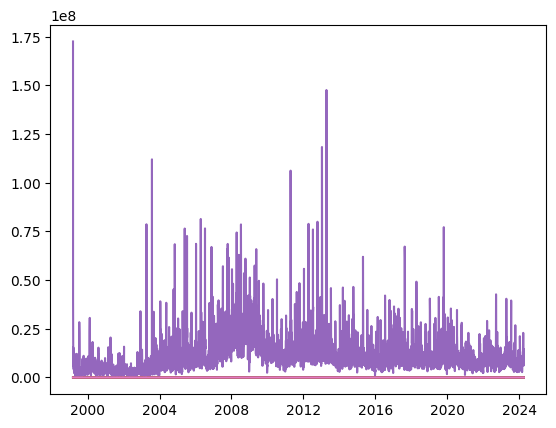

In [5]:
# plotting the stock
plt.plot(infy_df)

In [6]:
close_data_infy = infy_df["Close"]

close_data_infy

Date
1999-03-11 00:00:00-05:00     0.483835
1999-03-12 00:00:00-05:00     0.481255
1999-03-15 00:00:00-05:00     0.437387
1999-03-16 00:00:00-05:00     0.433516
1999-03-17 00:00:00-05:00     0.436097
                               ...    
2024-03-28 00:00:00-04:00    17.930000
2024-04-01 00:00:00-04:00    17.580000
2024-04-02 00:00:00-04:00    17.580000
2024-04-03 00:00:00-04:00    17.719999
2024-04-04 00:00:00-04:00    17.750000
Name: Close, Length: 6308, dtype: float64

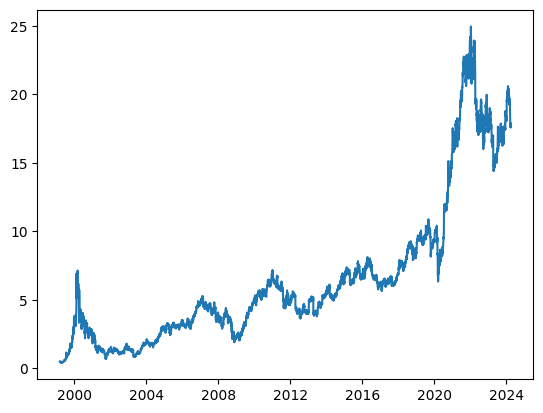

In [7]:
# plotting the price of stock on closing time
plt.plot(close_data_infy)

In [8]:
# real-valued data to discreet-valued data
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(close_data_infy).reshape(-1, 1))

In [9]:
df

array([[0.0028904 ],
       [0.00278531],
       [0.0009985 ],
       ...,
       [0.69923964],
       [0.704942  ],
       [0.70616397]])

In [10]:
# dividing data into training and testing sets
training_size = int(len(df)*0.7)
testing_size = int(len(df)) - training_size

print(f"Training size: {training_size} and testing size: {testing_size}")

Training size: 4415 and testing size: 1893


In [11]:
training_data, testing_data = df[0:training_size:], df[training_size:len(df):]

In [12]:
training_data

array([[0.0028904 ],
       [0.00278531],
       [0.0009985 ],
       ...,
       [0.25256716],
       [0.25457128],
       [0.24972802]])

In [13]:
testing_data

array([[0.2482249 ],
       [0.24889297],
       [0.24855896],
       ...,
       [0.69923964],
       [0.704942  ],
       [0.70616397]])

In [14]:
print(f"Length of training set: {len(training_data)}, calculated length: {training_size}")
print(f"Length of testing set: {len(testing_data)}, calculated length: {testing_size}")

Length of training set: 4415, calculated length: 4415
Length of testing set: 1893, calculated length: 1893


In [15]:
# creating datasets for predictions
def create_datasets(dataset, timesteps=1):
    data_x, data_y = [], []

    for i in range(len(dataset)-timesteps):
        data = dataset[i:(timesteps+i), 0]
        data_x.append(data)
        prev_data = dataset[i+timesteps, 0]
        data_y.append(prev_data)

    return np.array(data_x), np.array(data_y)

In [16]:
train_x, train_y = create_datasets(training_data, 250)
test_x, test_y = create_datasets(testing_data, 250)

In [17]:
train_x, train_y

(array([[0.0028904 , 0.00278531, 0.0009985 , ..., 0.23744915, 0.25953177,
         0.27341237],
        [0.00278531, 0.0009985 , 0.00084085, ..., 0.25953177, 0.27341237,
         0.26499978],
        [0.0009985 , 0.00084085, 0.00094596, ..., 0.27341237, 0.26499978,
         0.26920609],
        ...,
        [0.27266065, 0.27478919, 0.2752804 , ..., 0.25156507, 0.25256716,
         0.25123107],
        [0.27478919, 0.2752804 , 0.27871871, ..., 0.25256716, 0.25123107,
         0.25256716],
        [0.2752804 , 0.27871871, 0.29574684, ..., 0.25123107, 0.25256716,
         0.25457128]]),
 array([0.26499978, 0.26920609, 0.26920609, ..., 0.25256716, 0.25457128,
        0.24972802]))

In [18]:
test_x, test_y

(array([[0.2482249 , 0.24889297, 0.24855896, ..., 0.23673214, 0.23741742,
         0.23399099],
        [0.24889297, 0.24855896, 0.2482249 , ..., 0.23741742, 0.23399099,
         0.23313447],
        [0.24855896, 0.2482249 , 0.24672189, ..., 0.23399099, 0.23313447,
         0.22833759],
        ...,
        [0.67424163, 0.67225816, 0.67067129, ..., 0.70779326, 0.71349562,
         0.69923964],
        [0.67225816, 0.67067129, 0.6674977 , ..., 0.71349562, 0.69923964,
         0.69923964],
        [0.67067129, 0.6674977 , 0.67305144, ..., 0.69923964, 0.69923964,
         0.704942  ]]),
 array([0.23313447, 0.22833759, 0.22885156, ..., 0.69923964, 0.704942  ,
        0.70616397]))

In [19]:
train_x.shape, train_y.shape

((4165, 250), (4165,))

In [20]:
# reshape data into (batch size, timesteps, features)
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], 1)
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], 1)

In [21]:
train_x

array([[[0.0028904 ],
        [0.00278531],
        [0.0009985 ],
        ...,
        [0.23744915],
        [0.25953177],
        [0.27341237]],

       [[0.00278531],
        [0.0009985 ],
        [0.00084085],
        ...,
        [0.25953177],
        [0.27341237],
        [0.26499978]],

       [[0.0009985 ],
        [0.00084085],
        [0.00094596],
        ...,
        [0.27341237],
        [0.26499978],
        [0.26920609]],

       ...,

       [[0.27266065],
        [0.27478919],
        [0.2752804 ],
        ...,
        [0.25156507],
        [0.25256716],
        [0.25123107]],

       [[0.27478919],
        [0.2752804 ],
        [0.27871871],
        ...,
        [0.25256716],
        [0.25123107],
        [0.25256716]],

       [[0.2752804 ],
        [0.27871871],
        [0.29574684],
        ...,
        [0.25123107],
        [0.25256716],
        [0.25457128]]])

In [22]:
# building LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

c:\Users\Mehul\CODES\StockPrediction-Minor\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# train model
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

In [26]:
model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 274ms/step - accuracy: 0.0000e+00 - loss: 1.2697e-04 - val_accuracy: 6.0864e-04 - val_loss: 0.0013
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.0000e+00 - loss: 1.0899e-04 - val_accuracy: 6.0864e-04 - val_loss: 9.0859e-04
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.0000e+00 - loss: 1.0958e-04 - val_accuracy: 6.0864e-04 - val_loss: 0.0018
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - accuracy: 0.0000e+00 - loss: 1.0532e-04 - val_accuracy: 6.0864e-04 - val_loss: 7.9547e-04
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.0000e+00 - loss: 1.2342e-04 - val_accuracy: 6.0864e-04 - val_loss: 0.0016
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - accuracy: 0.0000e+00 - loss: 9.0701e-05 - val_accuracy: 6.0864e-04 - val_loss: 7.9679e-04
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 257ms/step - accuracy: 0.0000e+00 - loss: 8.8653e-05 - val_accuracy: 6.0864e-04 - val_loss: 0

In [48]:
with open('lstm_model.pkl', 'wb') as file:
    pickle.dump(model, file=file)

AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'

In [50]:
model.save('lstm_model.keras')

In [27]:
# predicting data
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step


In [28]:
train_predict

array([[0.27267763],
       [0.26133943],
       [0.26756588],
       ...,
       [0.25237405],
       [0.25401327],
       [0.25591397]], dtype=float32)

In [29]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [30]:
train_predict

array([[7.1074185],
       [6.8290524],
       [6.981919 ],
       ...,
       [6.6089425],
       [6.649187 ],
       [6.695852 ]], dtype=float32)

In [35]:
mse = mean_squared_error(train_y, train_predict)
rmse = np.sqrt(mse)

print(f"mean_squared_error: {mse}")
print(f"Root mean squared error: {rmse}")

mean_squared_error: [46.818695 43.031586 45.060513 ... 40.403507 40.89111  41.55251 ]
Root mean squared error: [6.8424187 6.5598464 6.712713  ... 6.356375  6.3946157 6.4461236]


In [36]:
mse = mean_squared_error(test_y, test_predict)
rmse = np.sqrt(rmse)

print(f"mean_squared_error: {mse}")
print(f"Root mean squared error: {rmse}")

mean_squared_error: [ 35.29479   35.24796   33.783028 ... 267.5491   283.40436  283.01712 ]
Root mean squared error: [2.6158018 2.5612197 2.5908904 ... 2.5211854 2.5287578 2.5389218]


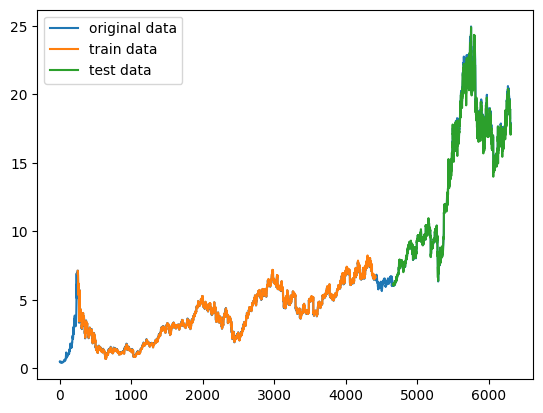

In [38]:
look_back=250
train_predict_plot = np.empty_like(df)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
test_predict_plot = np.empty_like(df)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)-1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df), label="original data")
plt.plot(train_predict_plot, label="train data")
plt.plot(test_predict_plot, label="test data")
plt.legend()
plt.show()

In [39]:
x_input = testing_data[len(testing_data)-250:].reshape(1, -1)
x_input.shape

(1, 250)

In [40]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [41]:
len(temp_input)

250

In [42]:
lst_output=[]
n_steps=250
i=0

while(i<30):
    
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.69867736]
251
1 day input [0.67305144 0.67543175 0.66035693 0.59410737 0.58537992 0.58577656
 0.57665244 0.57109855 0.57228866 0.57308206 0.57109855 0.56990847
 0.57228866 0.59053706 0.59966123 0.59767771 0.59966123 0.59331397
 0.59014038 0.58815683 0.58855355 0.58895027 0.59014038 0.57942931
 0.58141286 0.59172718 0.58260298 0.58577656 0.58418977 0.58815683
 0.60402497 0.59926455 0.60045466 0.60442169 0.61275249 0.61394257
 0.61632284 0.61966    0.6184538  0.60237097 0.61202066 0.61202066
 0.60397925 0.60438133 0.61885588 0.62046415 0.60880411 0.61121651
 0.61966    0.61202066 0.60196893 0.60518548 0.59432956 0.60639168
 0.61121651 0.61644341 0.62247447 0.62930965 0.63212412 0.63694898
 0.62930965 0.62850549 0.62689725 0.63614483 0.62930965 0.65825871
 0.66831048 0.67836225 0.70208429 0.69524908 0.63534067 0.63855722
 0.63534067 0.64177377 0.65142357 0.65182554 0.6449904  0.65303181
 0.65866075 0.64740287 0.64700075 0.65504209 0.65785667 0.65745456
 0.65504209 0.66147526 0.65383597

In [43]:
day_new=np.arange(1,251)
day_pred=np.arange(251, 281)

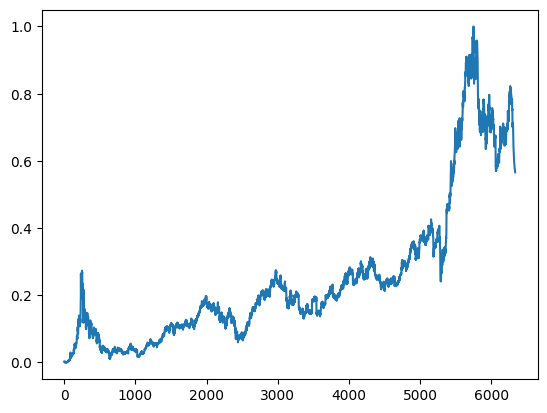

In [44]:
df2=df.tolist()
df2.extend(lst_output)
plt.plot(df2)

In [52]:
loaded_model = load_model('lstm_model.keras')

In [69]:
data2 = yf.download('AAPL', start='2021-02-01', end='2023-12-31')

[*********************100%%**********************]  1 of 1 completed


In [70]:
prediction = loaded_model.predict(data2["Close"])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


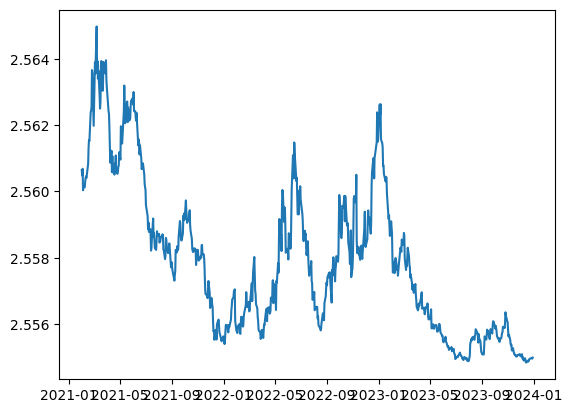

In [71]:
plt.plot(data2.index, prediction)